In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pprint
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import scipy
import matplotlib.patches as patches
import statsmodels.stats.api as sms
from sklearn.metrics import r2_score
import scipy.stats.kde as kde

# Read meta data (remove Beijing mice data since their SCFA data are incomplete)

In [6]:
df_meta = pd.read_excel('../../../../../data/meta_data.xlsx', index_col=0)
df_meta = df_meta[df_meta.Vendor != 'Beijing']
df_meta = df_meta[df_meta.Diet == 'Resistant starch']
df_meta.head()

,MiceID,Vendor,Day,Diet
SampleID,,,,
sample406,GR1,Guangdong,0,Resistant starch
sample407,GR2,Guangdong,0,Resistant starch
sample408,GR3,Guangdong,0,Resistant starch
sample409,GR4,Guangdong,0,Resistant starch
sample410,GR5,Guangdong,0,Resistant starch


# Read SCFA

In [8]:
df_scfa = pd.read_excel('../../../../../data/SCFA.xlsx', index_col=0)
df_scfa = df_scfa[['Acetate','Butyrate','Propionate']]
df_scfa = df_scfa.loc[df_meta.index]
df_scfa.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample406,8.483426,1.263977,1.850869
sample407,11.945646,0.956402,2.772971
sample408,11.208475,1.813452,1.765664
sample409,11.874095,2.632026,2.799104
sample410,11.656958,1.719326,2.622626


In [9]:
df_scfa.corr()

,Acetate,Butyrate,Propionate
Acetate,1.000000,0.664724,0.805789
Butyrate,0.664724,1.000000,0.584910
Propionate,0.805789,0.584910,1.000000


# Read 16S data

In [11]:
df_16S = pd.read_excel('../../../../../data/16S_absolute_abundance.xlsx', index_col=0)
df_16S = df_16S.loc[df_meta.index]
df_16S.columns = [c.replace('/','_slash_').replace(' ','_space_').replace('[','_leftsquarebracket_').replace(']','_rightsquarebracket_').replace('-','_dash_').replace('.','_dot_').replace('(','_leftroundbracket').replace(')','_rightroundbracket_') for c in df_16S.columns]
df_16S.head()

,A2,ASF356,Acetatifactor,Acetatifactor_dash_muris,Acidovorax,Acinetobacter,Acinetobacter_dash_sp_dot__dash_CIP_dash_56_dot_2,Acutalibacter_dash_muris,Adlercreutzia_dash_mucosicola,Adlercreutzia_dash_muris,...,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_ventriosum_dash_group,_leftsquarebracket_Eubacterium_rightsquarebracket__dash_xylanophilum_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_gnavus_dash_group,_leftsquarebracket_Ruminococcus_rightsquarebracket__dash_torques_dash_group,bacterium_dash_enrichment_dash_culture_dash_clone_dash_M153,gut_dash_metagenome,human_dash_gut_dash_metagenome,marine_dash_metagenome,metagenome,mouse_dash_gut_dash_metagenome
SampleID,,,,,,,,,,,,,,,,,,,,,
sample406,21101.413940,77742.051357,129940.285840,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,78852.652091,0.0,0.0,0.0,37760.424945,0.0,0.0,0.0,0.000000
sample407,54671.186297,70924.782223,56148.785926,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,119685.570001,0.0,0.0,0.0,203908.748890,0.0,0.0,0.0,39895.190000
sample408,12315.770413,153067.432274,60699.154178,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,87969.788663,0.0,0.0,0.0,34308.217579,0.0,0.0,0.0,112601.329489
sample409,6937.232567,74575.250097,12573.734028,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,26014.622127,0.0,0.0,0.0,3902.193319,0.0,0.0,0.0,84113.944877
sample410,0.000000,56775.462138,10918.358104,0.0,0.0,0.0,0.0,0.0,19653.044586,0.0,...,0.0,26204.059448,0.0,0.0,0.0,108091.745225,0.0,0.0,0.0,0.000000


# Select the 40 most abundant taxa

In [12]:
topX = 40
df_16S_T = df_16S.T
df_16S_T['mean'] = df_16S_T.mean(axis=1)
df_16S_T = df_16S_T.sort_values(by=['mean'],axis=0,ascending=False)
df_16S_T = df_16S_T.drop('mean', axis=1)
df_16S_topX = df_16S_T.iloc[0:topX].T
df_16S_topX.head()

,Muribaculaceae,Lachnospiraceae_dash_NK4A136_dash_group,Faecalibaculum,Bacteroides_dash_acidifaciens,Parabacteroides_dash_goldsteinii,Bacteroides,Alloprevotella,Lachnospiraceae,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Akkermansia_dash_muciniphila,...,Desulfovibrio,Odoribacter,Candidatus_dash_Saccharimonas,Lachnospiraceae_dash_UCG_dash_006,Helicobacter_dash_mastomyrinus,Tuzzerella,Lachnoclostridium,Lactobacillus,Lachnospiraceae_dash_bacterium_dash_DW59,Bilophila
SampleID,,,,,,,,,,,,,,,,,,,,,
sample406,1.625253e+07,2.295612e+06,1.118375e+06,4.298025e+05,222120.146735,4.531251e+05,1.388806e+07,2.764285e+06,81073.853558,2.892004e+06,...,57751.238151,1.274970e+06,1.645910e+06,265433.575348,174364.315187,274318.381218,360945.238445,145488.696112,96622.263830,14437.809538
sample407,1.828530e+07,1.490898e+06,1.994760e+05,2.077505e+06,437369.490374,2.081938e+06,1.240888e+07,4.443142e+06,82745.579260,2.330175e+06,...,45805.588519,4.097384e+06,2.176504e+06,342803.114077,599905.449634,307340.722965,716635.820376,100476.774816,36939.990741,0.000000
sample408,1.504811e+07,1.555306e+06,3.898821e+06,9.764647e+05,241916.918824,4.000866e+06,7.630499e+06,3.298867e+06,76533.716137,7.125553e+04,...,82691.601343,4.987887e+05,1.359133e+06,312292.749754,468878.973575,208488.399132,515502.961566,535736.012959,358916.737746,21112.749279
sample409,1.454131e+07,1.054459e+06,4.537817e+06,2.397681e+05,105359.219614,2.653491e+05,9.660096e+05,1.212715e+06,19510.966595,1.704825e+06,...,25147.468056,5.866297e+05,5.848954e+05,87148.984125,523327.481785,63735.824211,95820.524834,222425.019184,44224.857616,4335.770354
sample410,1.767027e+07,4.683976e+05,5.634965e+06,7.391728e+05,231469.191795,9.564482e+05,1.571043e+07,6.059689e+05,27295.895259,1.072620e+07,...,0.000000,4.902343e+05,2.041733e+05,87346.864828,620162.740280,121193.774949,44765.268224,218367.162071,104816.237794,0.000000


In [13]:
# sample with minimum absolute abundance coverage
(df_16S_topX.sum(axis=1)/df_16S.sum(axis=1)).min()

0.8823729936107215

# Calculate derivative

In [14]:
df_scfa_meta = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_scfa_deriv = deepcopy(df_scfa_meta)
for curr_mice in set(df_scfa_deriv.MiceID):
    curr_df = df_scfa_meta[df_scfa_meta.MiceID==curr_mice]
    for scfa in ['Acetate','Butyrate','Propionate']:
        xdata = np.array(curr_df['Day'])
        ydata = np.array(curr_df[scfa])
        cs = CubicSpline(xdata, ydata)
        csd1 = cs.derivative(nu=1)
        ydata_d1 = csd1(xdata)
        df_scfa_deriv.loc[df_scfa_deriv.MiceID==curr_mice, scfa] = ydata_d1
    
df_scfa_deriv = df_scfa_deriv[['Acetate','Butyrate','Propionate']]
df_scfa_deriv.head()

,Acetate,Butyrate,Propionate
SampleID,,,
sample406,0.601950,-1.625813,0.182595
sample407,0.176444,10.259601,0.518874
sample408,-11.774813,0.475036,-0.738201
sample409,7.877816,5.081010,6.151909
sample410,-1.801557,5.524064,-1.269226


# Normalize max value of 16S data to 1

In [15]:
# normalize bacteria data using 
bacterial_taxa = list(df_16S_topX.columns)
df_16S_topX = df_16S_topX/df_16S_topX.max().max()
df_16S_topX.head()

,Muribaculaceae,Lachnospiraceae_dash_NK4A136_dash_group,Faecalibaculum,Bacteroides_dash_acidifaciens,Parabacteroides_dash_goldsteinii,Bacteroides,Alloprevotella,Lachnospiraceae,Lachnospiraceae_dash_bacterium_dash_28_dash_4,Akkermansia_dash_muciniphila,...,Desulfovibrio,Odoribacter,Candidatus_dash_Saccharimonas,Lachnospiraceae_dash_UCG_dash_006,Helicobacter_dash_mastomyrinus,Tuzzerella,Lachnoclostridium,Lactobacillus,Lachnospiraceae_dash_bacterium_dash_DW59,Bilophila
SampleID,,,,,,,,,,,,,,,,,,,,,
sample406,0.090918,0.012842,0.006256,0.002404,0.001243,0.002535,0.077691,0.015464,0.000454,0.016178,...,0.000323,0.007132,0.009207,0.001485,0.000975,0.001535,0.002019,0.000814,0.000541,0.000081
sample407,0.102290,0.008340,0.001116,0.011622,0.002447,0.011647,0.069417,0.024855,0.000463,0.013035,...,0.000256,0.022921,0.012176,0.001918,0.003356,0.001719,0.004009,0.000562,0.000207,0.000000
sample408,0.084181,0.008701,0.021810,0.005462,0.001353,0.022381,0.042686,0.018454,0.000428,0.000399,...,0.000463,0.002790,0.007603,0.001747,0.002623,0.001166,0.002884,0.002997,0.002008,0.000118
sample409,0.081346,0.005899,0.025385,0.001341,0.000589,0.001484,0.005404,0.006784,0.000109,0.009537,...,0.000141,0.003282,0.003272,0.000488,0.002928,0.000357,0.000536,0.001244,0.000247,0.000024
sample410,0.098849,0.002620,0.031523,0.004135,0.001295,0.005350,0.087886,0.003390,0.000153,0.060003,...,0.000000,0.002742,0.001142,0.000489,0.003469,0.000678,0.000250,0.001222,0.000586,0.000000


# Simple Correlation

In [16]:
lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    for t in bacterial_taxa:
        lines.append([scfa,
                     t,
                     pearsonr(df_scfa_deriv[scfa],df_16S_topX[t])[0],
                     spearmanr(df_scfa_deriv[scfa],df_16S_topX[t])[0]]
                    )
df_corr = pd.DataFrame(lines, columns=['SCFA','Variable','Pearson','Spearman'])
df_corr.head()

,SCFA,Variable,Pearson,Spearman
0,Acetate,Muribaculaceae,-0.041651,0.045381
1,Acetate,Lachnospiraceae_dash_NK4A136_dash_group,-0.020845,0.050283
2,Acetate,Faecalibaculum,-0.021787,0.020832
3,Acetate,Bacteroides_dash_acidifaciens,0.040929,0.063579
4,Acetate,Parabacteroides_dash_goldsteinii,-0.008440,-0.023178


In [17]:
df_corr.to_excel('correlation_top40.xlsx')

# Elastic net

In [39]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    l1_ratio = [1e-4, .1, .3, .5, .7, .9, .95, .99, 1]
    reg = ElasticNetCV(
        eps=1e-4,
        n_alphas=10000,
        cv=5,
        random_state=0,
        max_iter=100000,
        tol=1e-6,
        l1_ratio=l1_ratio
    ).fit(X, dydt)
    clf = ElasticNet(l1_ratio=reg.l1_ratio_, 
                     alpha=reg.alpha_, 
                     random_state=0,
                     max_iter=100000,
                     tol=1e-6,
                    ).fit(X,dydt)
    rows.append([scfa, reg.alpha_, reg.l1_ratio_, clf.score(X,dydt)]+ list(clf.coef_))
df_elasticnet = pd.DataFrame(rows, columns=['SCFA','BestAlpha','L1Ratio','R2']+list(df_16S_topX.columns)).set_index('SCFA')
#df_elasticnet = df_elasticnet.loc[:, (df_elasticnet != 0).any(axis=0)]
df_elasticnet.head()

,BestAlpha,L1Ratio,R2,Muribaculaceae,Lachnospiraceae_dash_NK4A136_dash_group,Faecalibaculum,Bacteroides_dash_acidifaciens,Parabacteroides_dash_goldsteinii,Bacteroides,Alloprevotella,...,Desulfovibrio,Odoribacter,Candidatus_dash_Saccharimonas,Lachnospiraceae_dash_UCG_dash_006,Helicobacter_dash_mastomyrinus,Tuzzerella,Lachnoclostridium,Lactobacillus,Lachnospiraceae_dash_bacterium_dash_DW59,Bilophila
SCFA,,,,,,,,,,,,,,,,,,,,,
Acetate,303.965228,0.0001,0.000000,-1.298617e-19,-0.000000,-0.0,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
Butyrate,0.150706,0.1000,0.017465,-3.781605e-01,-0.112428,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
Propionate,298.425695,0.0001,0.000000,-0.000000e+00,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0


In [40]:
df_elasticnet = df_elasticnet.stack().reset_index()
df_elasticnet = df_elasticnet[~df_elasticnet.level_1.isin(['BestAlpha','L1Ratio','R2'])]
df_elasticnet.columns=['SCFA','Variable','Coefficient']
df_elasticnet = df_elasticnet.reset_index(drop=True)
df_elasticnet.to_excel('elasticnet_summary_top40.xlsx')

# Random forest regression

## parameter optimization

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

lines = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)

    # grid search
    rf = RandomForestRegressor()
    rf_random = GridSearchCV(
        estimator = rf, 
        param_grid = random_grid, 
        cv = 5, 
        verbose=2, 
        n_jobs = -1)

    # fit the random search model
    rf_random.fit(X, dydt)
    
    # write to table
    lines.append([scfa,
           rf_random.best_params_['n_estimators'],
           rf_random.best_params_['max_features'],
           rf_random.best_params_['max_depth'],
           rf_random.best_params_['min_samples_split'],
           rf_random.best_params_['min_samples_leaf'],
           rf_random.best_params_['bootstrap']
           ])

df_opt_paras = pd.DataFrame(lines, columns=['SCFA','n_estimators','max_features','max_depth','min_samples_split','min_samples_leaf','bootstrap'])
df_opt_paras.head()

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 24.4min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 22.4min finished


Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 18.9min finished


,SCFA,n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf,bootstrap
0,Acetate,200,sqrt,NaN,2,4,True
1,Butyrate,200,auto,20.0,5,1,True
2,Propionate,200,sqrt,NaN,2,4,True


In [25]:
df_opt_paras.to_excel('optimal_rf_hyperparameters_top40.xlsx')

## run RF using best parameters

In [26]:
rows = []
for scfa in ['Acetate','Butyrate','Propionate']:
    dydt = np.asarray(list(df_scfa_deriv[scfa]))
    X = np.asarray(df_16S_topX.values)
    regr = RandomForestRegressor(
        random_state=0,
        bootstrap=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'bootstrap'])[0],
        max_depth=None if str(list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0])=='nan' else list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_depth'])[0],
        max_features=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'max_features'])[0],
        min_samples_leaf=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_leaf'])[0],
        min_samples_split=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'min_samples_split'])[0],
        n_estimators=list(df_opt_paras.loc[df_opt_paras.SCFA==scfa,'n_estimators'])[0],
        n_jobs=-1
    )
    clf = regr.fit(X, dydt)
    rows.append([scfa, clf.score(X, dydt)]+ list(clf.feature_importances_))
df_rf = pd.DataFrame(rows, columns=['SCFA','R2']+list(df_16S_topX.columns))
df_rf.head()

,SCFA,R2,Muribaculaceae,Lachnospiraceae_dash_NK4A136_dash_group,Faecalibaculum,Bacteroides_dash_acidifaciens,Parabacteroides_dash_goldsteinii,Bacteroides,Alloprevotella,Lachnospiraceae,...,Desulfovibrio,Odoribacter,Candidatus_dash_Saccharimonas,Lachnospiraceae_dash_UCG_dash_006,Helicobacter_dash_mastomyrinus,Tuzzerella,Lachnoclostridium,Lactobacillus,Lachnospiraceae_dash_bacterium_dash_DW59,Bilophila
0,Acetate,0.470654,0.019015,0.048954,0.015968,0.015901,0.022011,0.051063,0.023956,0.021997,...,0.020248,0.013856,0.017979,0.019535,0.013186,0.017109,0.025119,0.028379,0.015420,0.013076
1,Butyrate,0.816062,0.019199,0.028423,0.063431,0.004026,0.010400,0.024346,0.009967,0.003331,...,0.005731,0.007468,0.013397,0.016501,0.001766,0.002560,0.009016,0.007975,0.079544,0.007669
2,Propionate,0.496737,0.027652,0.044705,0.021616,0.017255,0.021960,0.087944,0.024531,0.026173,...,0.017098,0.018898,0.015122,0.020525,0.012243,0.019117,0.021538,0.016400,0.020931,0.014779


In [27]:
df_rf = df_rf.set_index('SCFA').stack().reset_index()
df_rf = df_rf[~df_rf.level_1.isin(['R2'])]
df_rf.columns=['SCFA','Variable','Gini']
df_rf = df_rf.reset_index(drop=True)
df_rf.to_excel('rf_importance_top40.xlsx')

# Combine results

In [14]:
df_corr = pd.read_excel('correlation_top40.xlsx', index_col=0)
df_corr = df_corr.drop('Spearman', axis=1)
df_corr.head()

,SCFA,Variable,Pearson
0,Acetate,Muribaculaceae,-0.041651
1,Acetate,Lachnospiraceae_dash_NK4A136_dash_group,-0.020845
2,Acetate,Faecalibaculum,-0.021787
3,Acetate,Bacteroides_dash_acidifaciens,0.040929
4,Acetate,Parabacteroides_dash_goldsteinii,-0.008440


In [15]:
df_elasnet = pd.read_excel('elasticnet_summary_top40.xlsx', index_col=0)
df_elasnet.head()

,SCFA,Variable,Coefficient
0,Acetate,Muribaculaceae,-1.298617e-19
1,Acetate,Lachnospiraceae_dash_NK4A136_dash_group,0.000000e+00
2,Acetate,Faecalibaculum,0.000000e+00
3,Acetate,Bacteroides_dash_acidifaciens,0.000000e+00
4,Acetate,Parabacteroides_dash_goldsteinii,0.000000e+00


In [16]:
df_rf = pd.read_excel('rf_importance_top40.xlsx', index_col=0)
df_rf.head()

,SCFA,Variable,Gini
0,Acetate,Muribaculaceae,0.019015
1,Acetate,Lachnospiraceae_dash_NK4A136_dash_group,0.048954
2,Acetate,Faecalibaculum,0.015968
3,Acetate,Bacteroides_dash_acidifaciens,0.015901
4,Acetate,Parabacteroides_dash_goldsteinii,0.022011


In [18]:
df_joined = pd.merge(df_rf, df_corr, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined = pd.merge(df_joined, df_elasnet, left_on=['SCFA','Variable'], right_on=['SCFA','Variable'], how='inner')
df_joined.columns = ['SCFA','Taxon','RandomForest','Pearson','ElasticNet']
df_joined['Taxon'] = [t.replace('_dash_','-').replace('_dot_','.') for t in df_joined['Taxon']]
df_joined.head()

,SCFA,Taxon,RandomForest,Pearson,ElasticNet
0,Acetate,Muribaculaceae,0.019015,-0.041651,-1.298617e-19
1,Acetate,Lachnospiraceae-NK4A136-group,0.048954,-0.020845,0.000000e+00
2,Acetate,Faecalibaculum,0.015968,-0.021787,0.000000e+00
3,Acetate,Bacteroides-acidifaciens,0.015901,0.040929,0.000000e+00
4,Acetate,Parabacteroides-goldsteinii,0.022011,-0.008440,0.000000e+00


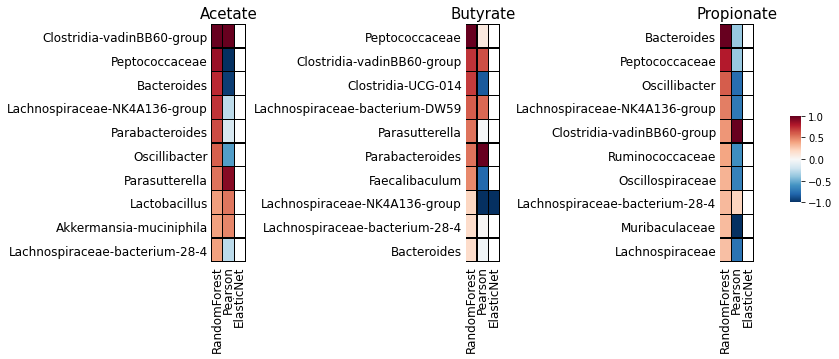

In [19]:
fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=3, constrained_layout=True, sharex=True)
cbar_ax = fig.add_axes([0.94, .45, .015, .2])
for k,scfa in enumerate(['Acetate','Butyrate','Propionate']):
    curr_df = df_joined[df_joined.SCFA==scfa].set_index('Taxon')
    curr_df = curr_df.drop('SCFA', axis=1)
    curr_df = curr_df.sort_values(by='RandomForest', ascending=False)
    curr_df = curr_df.iloc[0:10,:]
    
    # normalize to -1 and 1
    for c in ['Pearson','ElasticNet','RandomForest']:
        if c!='RandomForest':
            curr_df.loc[curr_df[c]<0,c] = curr_df.loc[curr_df[c]<0,c]/np.abs(curr_df.loc[curr_df[c]<0,c].min())
        curr_df.loc[curr_df[c]>=0,c] = curr_df.loc[curr_df[c]>=0,c]/curr_df.loc[curr_df[c]>=0,c].max()

    # plot    
    _ = sns.heatmap(curr_df.values, ax=ax[k], cmap='RdBu_r', vmin=-1, vmax=1, cbar = False if k!=2 else True, cbar_ax = None if k!=2 else cbar_ax, linewidths=0.25, linecolor='black')
    ax[k].set_xticklabels(['RandomForest','Pearson','ElasticNet'], rotation=90, fontsize=12)
    ax[k].set_title(scfa, fontsize=15)
    ax[k].set_yticklabels(curr_df.index, rotation=0, fontsize=12)
    ax[k].tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()

In [48]:
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_producer_all_methods.pdf", format="pdf")